# Preámbulo

In [1]:
%pip install astropy==5.3.4
%pip install aplpy
%pip install matplotlib==3.9
%pip install ccdproc
%pip install photutils==1.13.0

In [2]:
import aplpy
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import wcs
from astropy.coordinates import SkyCoord
from scipy.optimize import curve_fit
from astropy.wcs import WCS
import re
import ccdproc as ccdp
from astropy.nddata import CCDData
from astropy import units as u
import photutils as pht
from photutils.profiles import RadialProfile
from scipy.ndimage import rotate

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
def zoom(RA,DEC,tamano_corte,header,data):
  """
  Función que recorta la imagen y genera un zoom.

  Parámetros:
    RA: str, Coordenada RA.
    DEC: str, Coordenada DEC.
    tamano_corte: int.
    header: var, header del RAW.
    data: var, data del RAW.
  """
  # ==========================================================
  # Cambio de coordenadas celestiales a coordenadas pixelares.
  # ==========================================================

  w = wcs.WCS(header)
  coords = SkyCoord(RA,DEC,frame='icrs') # Variable que guarda ambas coordenadas.
  x_pix, y_pix = w.wcs_world2pix(coords.ra.deg, coords.dec.deg, 1) # Conversión

  # ==============================================================
  # Recorte de la imagen según el tamaño indicado y visualización.
  # ==============================================================

  cut_data = data[int(y_pix-tamano_corte/2):int(y_pix+tamano_corte/2),
                  int(x_pix-tamano_corte/2):int(x_pix+tamano_corte/2)]
  return cut_data

In [5]:
def _to_identifier(label):
    """
    Convierte la etiqueta en un identificador Python válido.
    Reemplaza caracteres no alfanuméricos por guiones bajos.

    Parámetros:
      label: str, etiqueta a convertir.
    """
    # Reemplaza no alfanum por _.
    s = re.sub(r'\W', '_', str(label))
    if s and s[0].isdigit():
        s = '_' + s # La etiqueta no puede empezar con dígitos.
    return s or 'etiqueta'

def datos_fits(ruta_del_archivo, etiqueta_del_archivo, ext=1, register_globals=True, memmap=True):
    """
    Abre un FITS y crea variables globales nombradas con la etiqueta:
      hdu_{etiqueta}, header_{etiqueta}, data_{etiqueta}, w_{etiqueta}
    También retorna un dict con esas referencias.

    Parámetros:
      ruta_del_archivo: str, ruta al FITS.
      etiqueta_del_archivo: str, e.g.' _bias1'.
      ext: int, extensión a usar (por defecto 1).
      register_globals: bool, si: True, crea variables globales.
      memmap: bool, si: True, utiliza mapeo a memoria.

    Nota: cierra el HDUList con hdu_{etiqueta}.close() cuando termines.
    """
    etiqueta = _to_identifier(etiqueta_del_archivo)

    hdul = fits.open(ruta_del_archivo, memmap=memmap)
    try:
        hdu = hdul[ext]
    except IndexError:
        hdul.close()
        raise ValueError(f"El archivo no tiene la extensión {ext}.")

    header = hdu.header
    data = hdu.data
    w = WCS(header)

    if register_globals:
        g = globals()
        g[f"hdu_{etiqueta}"] = hdul
        g[f"header_{etiqueta}"] = header
        g[f"data_{etiqueta}"] = data
        g[f"w_{etiqueta}"] = w

    return

In [6]:
def imagen(data):
  '''
  Función que visualiza una imagen.
  '''
  f = aplpy.FITSFigure(data)
  f.show_grayscale()
  return

In [7]:
def apert_fot_mag(data,header,coord_x,coord_y,apertura,offset_apertura_out):
  """
  Esta función realiza fotometría de apertura con el método offset.
  Adicionalmente, calcula la magnitud instrumental de la estrella y entrega el AIRMASS para cada conjunto de datos.

  Parámetros:
    - data: var, data del archivo.
    - header: var, header del archivo.
    - coord_x: float, coordenada pixelar para RA calculada a través de centroides_perfil_de_brillo.
    - coord_y: float, coordenada pixelar para DEC calculada a través de centroides_perfil_de_brillo.
    - apertura: int, cantidad en píxeles del radio al cual el perfil de brillo se vuelve lineal.
    - offset_apertura_out: int, offset para el método del offset.

  Esta función da como resultado la magnitud instrumental calculada con los métodos del anillo y offset, y entrega el AIRMASS según el archivo.
  """

  # =======================
  # Definición de regiones.
  # =======================

  # Se define una apertura centrada en la estrella cuyo radio es el máximo que aporta a la fotometría.
  apertura_estrella = pht.aperture.CircularAperture((coord_x,coord_y),r=apertura)

  # Se define una apertura del mismo radio pero desplazada con respecto a la estrella de interés con el fin
  # de determinar el flujo en una region vacia.
  apertura_out = pht.aperture.CircularAperture((coord_x-offset_apertura_out,coord_y-offset_apertura_out),r=apertura)

  # Se grafican las aperturas y anillo indicado.
  plt.imshow(data, interpolation='nearest', cmap='inferno', origin='lower')
  plt.xlabel('Pixels')
  plt.ylabel('Pixels')
  apertura_estrella.plot(color='white', lw=2, label='Apertura de Fotometría')
  apertura_out.plot(color='yellow', lw=2, label='Apertura Background')
  plt.legend()
  plt.show()

  # =========================================
  # Cálculo de flujo y magnitud instrumental.
  # =========================================

  # Se calcula el flujo total de la apertura sobre el fondo.
  suma_apertura_out = pht.aperture.aperture_photometry(data,apertura_out)

  # Se calcula el flujo total de la apertura sobre la estrella
  suma_apertura = pht.aperture.aperture_photometry(data,apertura_estrella)

  # Flujo
  flujo_sin_out = suma_apertura['aperture_sum'] - suma_apertura_out['aperture_sum']

  # Se calcula la magnitud instrumental a partir del número de cuentas obtenido.
  mag_offset = -2.5*np.log10(flujo_sin_out[0]/header['EXPTIME'])
  airmass = header['AIRMASS']
  return print(f'Magnitud con offset: {mag_offset}, Airmass: {airmass}')

In [8]:
def cambiacoordenadas(RA,DEC,header):
    '''
    Función que convierte coordenadas celestiales a coordenadas pixelares.

    Parámetros:
        RA: str, Coordenada RA.
        DEC: str, Coordenada DEC.
        header: var, header del RAW.
    '''
    w = wcs.WCS(header)
    coords = SkyCoord(RA,DEC,frame='icrs') # Variable que guarda ambas coordenadas.
    x_pix, y_pix = w.wcs_world2pix(coords.ra.deg, coords.dec.deg, 1) # Conversión
    return float(x_pix), float(y_pix)

In [9]:
def centroides_perfil_de_brillo(data_cortada,label,radio_max):
  """
  Función que encuentra los centroides de la imagen usando el método QUAD y luego calcula un perfil de brillo para la estrella.

  Parámetros:
    data_cortada: var, imagen recortada.
    label: str, etiqueta para el gráfico.
    radio_max: int, radio máximo para el perfil de brillo.
  """
  # Buscamos los centroides usando el método QUAD.
  x_quad, y_quad = pht.centroids.centroid_quadratic(data_cortada) # Busca máximos con quad.

  # Ploteamos TPH
  plt.imshow(data_cortada,origin='lower')
  plt.scatter(x_quad,y_quad,marker='x',label=f'Quad, x={x_quad:.5f}, y={y_quad:.5f}',s=50)
  plt.legend()
  plt.show()

  radial_bins = np.arange(0,radio_max)
  rp = RadialProfile(data_cortada,(x_quad,y_quad),radial_bins,mask=None,method='exact',subpixels=5)

  radius_points =  rp.radius
  cumulative_counts = np.cumsum(rp.profile)

  plt.plot(radius_points,cumulative_counts,':o',color='purple')
  plt.xlabel('Radio')
  plt.ylabel('Cuentas')
  plt.title(label)
  plt.grid()
  plt.show()

  print(f'x = {x_quad}, y = {y_quad}')
  return
  return

In [10]:
def b(x,m,c):
  return m*x + c

In [11]:
def recta_bouger_ZP_coefATM(mag,airmass,magnitud_catalogo):
  popt,_ = curve_fit(b,airmass,mag)

  plt.scatter(airmass,mag)
  plt.plot(airmass,b(airmass,popt[0],popt[1]),'r-',label=str(popt[0].round(2))+'x'+str(popt[1].round(2)))
  plt.xlabel('Airmass')
  plt.ylabel('Magnitude')
  plt.legend()
  plt.show()
  # Se calcula el ZP a partir de la magnitud para un airmass = 0 (punto donde la recta de Bouger intersecta al eje Y)
  # m0 = b(X=0)

  m0 = b(0,popt[0],popt[1])
  zp = magnitud_catalogo - m0

  print(f'Coeficiente de absorción atmosférico: {str(popt[0].round(2))}')
  print(f'Zero Point: {zp}')
  return

In [12]:
def curva_saturacion_recorte(RA,DEC,tamano_corte,header,data):
  """
  Esta función recorta una imagen ajustada al objeto de interés (en el archivo
  RAW) y luego genera una curva que indica la cantidad de electrones en la fila
  y columna centrales del objeto con el fin de determinar si el CCD está
  saturado o no.

  Adicionalmente, muestra la imagen recortada.

  Parámetros:
    RA: string, coordenadas RA del objeto de interés.
    DEC: string, coordenadas DEC del objeto de interés.
    tamano_corte: int, tamaño del corte de la imagen.
    header: var, header del archivo.
  """

  # ==========================================================
  # Cambio de coordenadas celestiales a coordenadas pixelares.
  # ==========================================================

  w = wcs.WCS(header)
  coords = SkyCoord(RA,DEC,frame='icrs') # Variable que guarda ambas coordenadas.
  x_pix, y_pix = w.wcs_world2pix(coords.ra.deg, coords.dec.deg, 1) # Conversión

  # ==============================================================
  # Recorte de la imagen según el tamaño indicado y visualización.
  # ==============================================================

  cut_data = data[int(y_pix-tamano_corte/2):int(y_pix+tamano_corte/2),
                  int(x_pix-tamano_corte/2):int(x_pix+tamano_corte/2)]

  # ====================================
  # Generación del gráfico para la fila.
  # ====================================
  plt.scatter(np.arange(0,len(cut_data[:,int(tamano_corte/2)])), cut_data[:,int(tamano_corte/2)], s=1)
  plt.ylabel('N° de cuentas')
  plt.xlabel('Pixel en la fila')
  plt.show()
  return

# Fotometría y determinación de magnitud instrumental para TYC 4898-141-1

Se realizará fotometría a la estrella TYC 4898-141-1 del campo estelar PG0942-029 y se determinará su magnitud instrumental con cierto archivo CLEAN. Para ello, se utilizarán los parámetros de coeficiente de absorción atmosférico y zero point de los filtro B y V calculados en el notebook anterior.
Primeramente, se realizará una curva de saturación que pase por el centro del objeto de interés.

In [18]:
# Se carga el archivo a utilizar, para el filtro B y V, respectivamente y los headers de los archivos BANZAI asociados (explicación en el notebook CALIBRACION).
ruta_clean_189 ='/content/drive/MyDrive/Colab Notebooks/Observacional VSCode/Clean Data/campo_reducido_189.fits'
ruta_clean_190 ='/content/drive/MyDrive/Colab Notebooks/Observacional VSCode/Clean Data/campo_reducido_190.fits'
datos_fits(ruta_clean_189,'clean_189',ext=0,memmap=False)
datos_fits(ruta_clean_190,'clean_190',ext=0,memmap=False)

ruta_BANZAI_189 = '/content/drive/MyDrive/Colab Notebooks/Observacional VSCode/BANZAIs/coj1m011-fa12-20241223-0189-e91.fits.fz'
ruta_BANZAI_190 = '/content/drive/MyDrive/Colab Notebooks/Observacional VSCode/BANZAIs/coj1m011-fa12-20241223-0190-e91.fits.fz'
datos_fits(ruta_BANZAI_189,'BANZAI_189',ext=0,memmap=False)
datos_fits(ruta_BANZAI_190,'BANZAI_190',ext=0,memmap=False)

Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -31.272933 from OBSGEO-[XYZ].
Set OBSGEO-H to     1164.993 from OBSGEO-[XYZ]'.


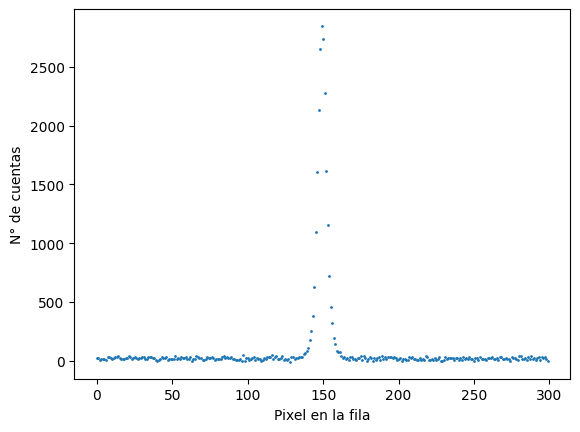

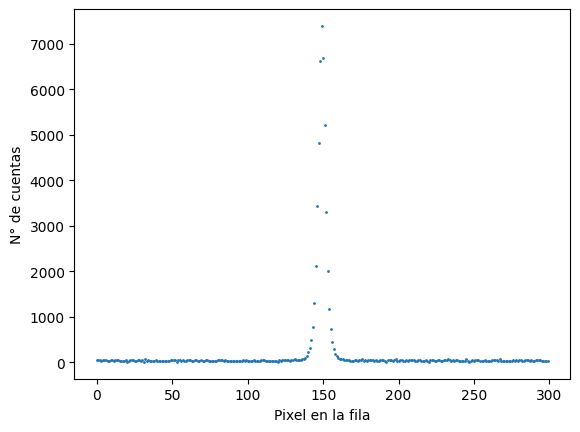

In [20]:
# Las coordenadas fueron extraidas de SIMBAD.
curva_saturacion_recorte('09h45m16.8459943704s','-03d02m52.730767608s',300,header_BANZAI_189,data_clean_189)
curva_saturacion_recorte('09h45m16.8459943704s','-03d02m52.730767608s',300,header_BANZAI_190,data_clean_190)

In [22]:
# Número de cuentas máximo que soporta el CCD.
print(header_BANZAI_189['SATURATE'])
print(header_BANZAI_190['SATURATE'])

113400.00000000001
113400.00000000001


Notar que ninguna curva de saturación excede las 113400 cuentas, por lo que es posible realizar la fotometría del objeto. Se procede con el cálculo de sus centroides y perfil de brillo.

In [23]:
data_cortada_clean_189 = zoom('09h45m16.8459943704s','-03d02m52.730767608s',300,header_BANZAI_189,data_clean_189)
data_cortada_clean_190 = zoom('09h45m16.8459943704s','-03d02m52.730767608s',300,header_BANZAI_190,data_clean_190)

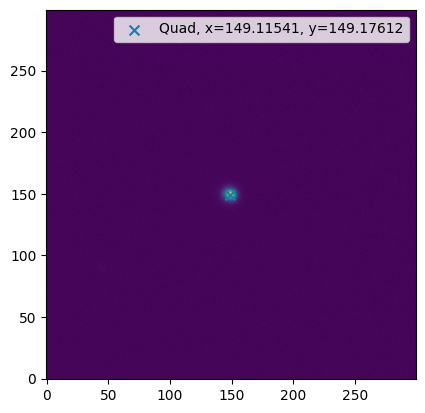

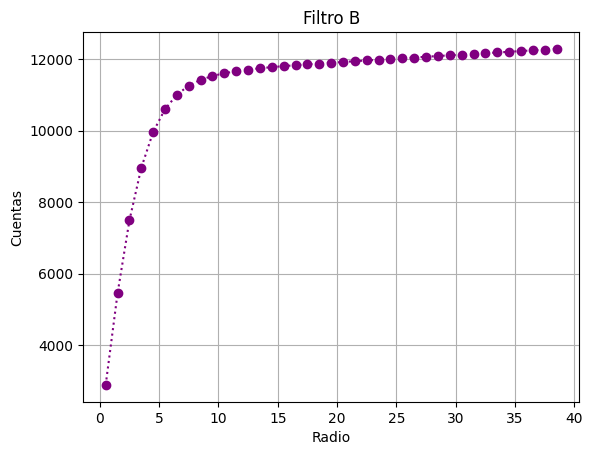

x = 149.11541453936036, y = 149.17612250236428


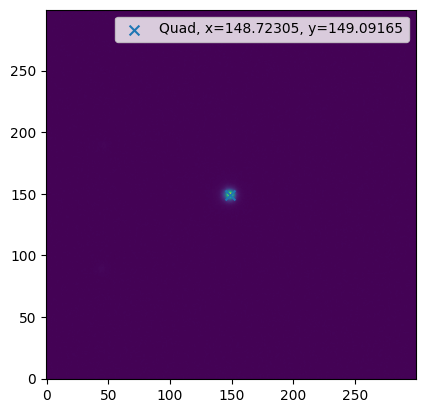

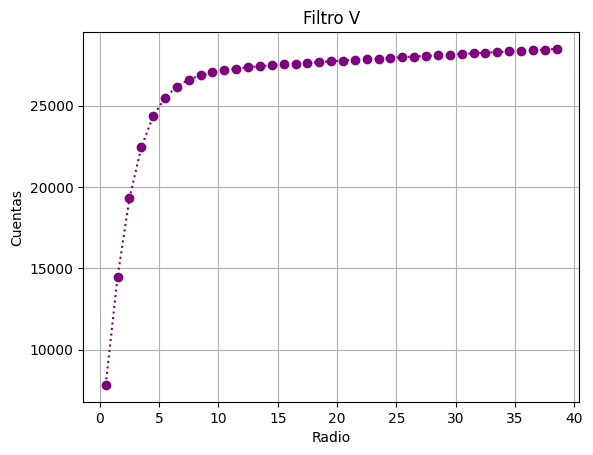

x = 148.72304786926045, y = 149.09164840349445


In [24]:
centroides_perfil_de_brillo(data_cortada_clean_189,'Filtro B',40)
centroides_perfil_de_brillo(data_cortada_clean_190,'Filtro V',40)

Aquí es importante destacar que para el filtro B, la apertura de la fotometría debe ser de $15[px]$, y para el filtro V de $12[pc]$. Se calcula la magnitud instrumental para cada filtro.

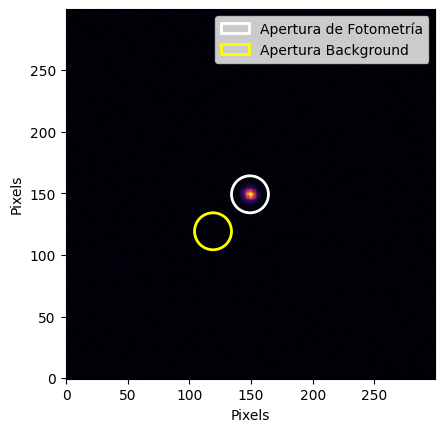

Magnitud con offset: -10.291984705274071, Airmass: 1.4878881


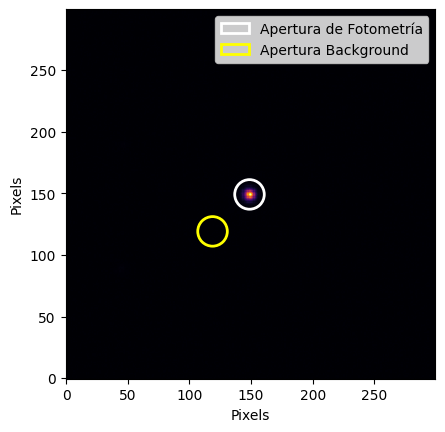

Magnitud con offset: -11.055848802391221, Airmass: 1.4835817


In [26]:
apert_fot_mag(data_cortada_clean_189,header_BANZAI_189,149.11541453936036,149.17612250236428,15,30)
apert_fot_mag(data_cortada_clean_190,header_BANZAI_190,148.72304786926045,149.09164840349445,12,30)

Con esto, se obtienen dos valores de magnitud instruental:
- $m_{i,filtro\;B}=-10.291984705274071$.
- $m_{i,filtro\;V}=-11.055848802391221$.

Para sus respectivos AIRMASS:
- $airmass_B=1.4878881$.
- $airmass_V=1.4835817$.

# Resultados

Usando los parámetros:
- Coeficiente de absorción atmosférico para el filtro B es: 0.614
- Valor para el zero pint en el filtro B es: 24.13913595496819
- Coeficiente de absorción atmosférico para el filtro V es: 0.6020000000000001
- Valor para el zero pint en el filtro B es: 24.30424473686704

su magnitud calibrada para cada filtro es la siguiente:

In [28]:
k_B = 0.614
zp_B = 24.13913595496819
k_V = 0.6020000000000001
zp_V = 24.30424473686704

In [32]:
m_calibrada_filtro_B = -10.286134502705629-k_B*1.4878881+zp_B
print(f'Su magnitud calibrada en el filtro B: {m_calibrada_filtro_B}')

Su magnitud calibrada en el filtro B: 12.939438158862561


In [31]:
m_calibrada_filtro_V = -11.060950113138956-k_V*1.4878881+zp_V
print(f'Su magnitud calibrada en el filtro V: {m_calibrada_filtro_V}')

Su magnitud calibrada en el filtro V: 12.347585987528085
